In [1]:
import os, sys, math
import numpy as np
import scipy
import trimesh
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("..")
import coarsening
from mesh_visualization import *
from obj_loader import *

# Enable autoload, since external python file will be changed after imported
%load_ext autoreload
%autoreload 1
%aimport coarsening, mesh_visualization, obj_loader

searching for scad in: /usr/local/bin:/Users/vrlab/anaconda3/condabin:/Users/vrlab/Library/Android/sdk/platform-tools:/usr/local/opt/gettext/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/VMware Fusion.app/Contents/Public:/Library/TeX/texbin:/opt/X11/bin:/Library/Frameworks/Mono.framework/Versions/Current/Commands:/Applications/OpenSCAD.app/Contents/MacOS


In [21]:
m = load_obj_ex("../trainDome/f_c_10412256613/f_c_10412256613_model.obj", raw_mesh=True)

In [38]:
adjacent_mat = m.edges_sparse
levels = 20
graphs, _, perm_mats = coarsening.metis(adjacent_mat, levels)
# graphs, perms, perm_mats = coarsening.coarsen(adjacent_mat, 10, self_connections=False)

In [39]:
pooled_vertices = m.vertices
l = 0
for l in range(levels):
    if l >= 1:
        perm_mat = perm_mats[l-1]
        degrees = perm_mat.getnnz(axis=1)
        degrees = scipy.sparse.diags(1/degrees)
        perm_mat = degrees * perm_mat
        pooled_vertices = scipy.sparse.csr_matrix.dot(perm_mat, pooled_vertices)

    if l % 4 != 0: continue

    A = graphs[l].tocoo()
    edges = np.hstack((A.row[:, np.newaxis], A.col[:, np.newaxis]))
    
    print("Level %d - vertices: %d, edges: %d" % (l, A.shape[0], edges.shape[0]))
    
    mesh = {
        "vertices": pooled_vertices
        , "edges": edges
    }
    display_mesh(mesh)
    

Level 0 - vertices: 49993, edges: 300000


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

Level 4 - vertices: 9642, edges: 57858


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

Level 8 - vertices: 1745, edges: 10464


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

Level 12 - vertices: 347, edges: 2076


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

Level 16 - vertices: 62, edges: 338


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

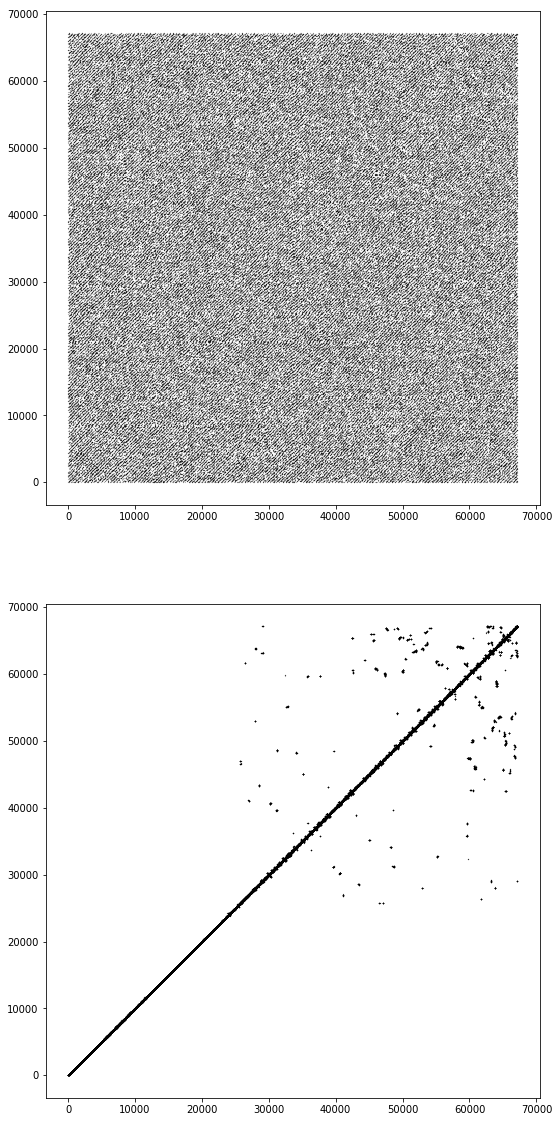

In [21]:
plt.gcf().set_figheight(20.0)
plt.gcf().set_figwidth(20.0)

plt.subplot(2, 1, 1, aspect='equal')
adjacent_mat = m.edges_sparse
coo = adjacent_mat.tocoo()
plt.plot(coo.col, coo.row, 'o', color='black', ms=0.1)

plt.subplot(2, 1, 2, aspect='equal')
coo = graphs[0].tocoo()

# Eliminate empty rows and columns
reorder = np.argsort(coo.row)
row = coo.row[reorder]
col = coo.col[reorder]
data = coo.data
uni_row, inv_row = np.unique(row, return_inverse=True)
uni_col, inv_col = np.unique(col, return_inverse=True)
M = uni_row.shape[0]
reindex = np.arange(M)
align = np.searchsorted(uni_row, uni_col, side='left')
row = reindex[inv_row]
col = reindex[align][inv_col]
coo = scipy.sparse.coo_matrix((data, (row, col)), shape=(M, M), dtype=np.float32)

plt.plot(coo.col, coo.row, 'o', color='black', ms=0.1)
plt.show()

In [63]:
import numpy as np
import collections
import trimesh

from trimesh.visual.color import to_float
from trimesh.visual.texture import unmerge_faces, TextureVisuals
from trimesh.visual.material import SimpleMaterial
from trimesh.visual.resolvers import FilePathResolver

from trimesh import util
from trimesh.exchange import misc
from trimesh.constants import log, tol
from trimesh.exchange.obj import parse_mtl, _parse_vertices, _preprocess_faces \
    , _group_by_material, _parse_faces_vectorized, _parse_faces_fallback

def load_obj_ex(path,
             raw_mesh=False,
             resolver=None,
             split_object=False,
             group_material=True
):
    """
    Load a Wavefront OBJ file into kwargs for a trimesh.Scene
    object.
    Parameters
    --------------
    file : file path
      Contains OBJ data
    raw_mesh : bool
      Only load the geometry data, e.g. vertices, faces. Ignore
      materials, uv, etc.
    resolver : trimesh.visual.resolvers.Resolver
      Allow assets such as referenced textures and
      material files to be loaded
    split_object : bool
      Split meshes at each `o` declared in file
    group_material : bool
      Group faces that share the same material
      into the same mesh.
    Returns
    -------------
    geometry : dict, trimesh.Trimesh or trimesh.PointCloud
      Loaded geometry parts of obj file. Each part has a name,
      which corresponds to a submesh
      If only one geometry found, a single trimesh.Trimesh
      or trimesh.PointCloud will be returned
    """
    geometry = {}
    try:
        with open(path, 'r') as f:
            geometry = _load_obj_impl(f, raw_mesh, resolver, split_object, group_material)
    except OSError:
        pass

    if len(geometry) == 1:
        return next(iter(geometry.values()))
    return geometry

def _load_obj_impl(file_obj,
             raw_mesh=False,
             resolver=None,
             split_object=False,
             group_material=True
):
    """
    Load a Wavefront OBJ file into kwargs for a trimesh.Scene
    object.
    Parameters
    --------------
    file : file like object
      Contains OBJ data
    raw_mesh : bool
      Only load the basic geometry data, e.g. vertices, faces. Ignore
      materials, uv, etc. Besides, the vertices and faces will keep
      consistent with the raw data.
    resolver : trimesh.visual.resolvers.Resolver
      Allow assets such as referenced textures and
      material files to be loaded
    split_object : bool
      Split meshes at each `o` declared in file
    group_material : bool
      Group faces that share the same material
      into the same mesh.
    Returns
    -------------
    geometry : dict
      Loaded geometry parts of obj file. Each part has a name,
      which corresponds to a submesh
    """
    
    # if we still have no resolver try using file_obj name
    if resolver is None and hasattr(file_obj, 'name') and len(file_obj.name) > 0 :
        resolver = FilePathResolver(file_obj.name)

    # get text as bytes or string blob
    text = file_obj.read()

    # if text was bytes decode into string
    text = util.decode_text(text)

    # add leading and trailing newlines so we can use the
    # same logic even if they jump directly in to data lines
    text = '\n{}\n'.format(text.strip().replace('\r\n', '\n'))

    # Load Materials
    materials = {}
    if not raw_mesh:
        mtl_position = text.find('mtllib')
        if mtl_position >= 0:
            # take the line of the material file after `mtllib`
            # which should be the file location of the .mtl file
            mtl_path = text[mtl_position + 6:text.find('\n', mtl_position)].strip()
            try:
                # use the resolver to get the data
                material_kwargs = parse_mtl(resolver[mtl_path], resolver=resolver)
                # turn parsed kwargs into material objects
                materials = {k: SimpleMaterial(**v) for k, v in material_kwargs.items()}
            except IOError:
                # usually the resolver couldn't find the asset
                log.warning('unable to load materials from: {}'.format(mtl_path))
            except BaseException:
                # something else happened so log a warning
                log.warning('unable to load materials from: {}'.format(mtl_path), exc_info=True)

    # extract vertices from raw text
    v, vn, vt, vc = _parse_vertices(text=text)

    # get relevant chunks that have face data
    # in the form of (material, object, chunk)
    face_tuples = _preprocess_faces(
        text=text, split_object=split_object)

    # combine chunks that have the same material
    # some meshes end up with a LOT of components
    # and will be much slower if you don't do this
    if group_material:
        face_tuples = _group_by_material(face_tuples)

    # Load Faces
    # now we have clean- ish faces grouped by material and object
    # so now we have to turn them into numpy arrays and kwargs
    # for trimesh mesh and scene objects
    geometry = {}
    while len(face_tuples) > 0:
        # consume the next chunk of text
        material, current_object, chunk = face_tuples.pop()
        # do wangling in string form
        # we need to only take the face line before a newline
        # using builtin functions in a list comprehension
        # is pretty fast relative to other options
        # this operation is the only one that is O(len(faces))
        # slower due to the tight-loop conditional:
        # face_lines = [i[:i.find('\n')]
        #              for i in chunk.split('\nf ')[1:]
        #              if i.rfind('\n') >0]
        # maxsplit=1 means that it can stop working
        # after it finds the first newline
        # passed as arg as it's not a kwarg in python2
        face_lines = [i.split('\n', 1)[0]
                      for i in chunk.split('\nf ')[1:]]
        # then we are going to replace all slashes with spaces
        joined = ' '.join(face_lines).replace('/', ' ')

        # the fastest way to get to a numpy array
        # processes the whole string at once into a 1D array
        # also wavefront is 1-indexed (vs 0-indexed) so offset
        array = np.fromstring(joined, sep=' ', dtype=np.int64) - 1

        # get the number of raw 2D columns in a sample line
        columns = len(face_lines[0].strip().replace('/', ' ').split())

        # make sure we have the right number of values for vectorized
        if len(array) == (columns * len(face_lines)):
            # everything is a nice 2D array
            faces, faces_tex, faces_norm = _parse_faces_vectorized(
                array=array,
                columns=columns,
                sample_line=face_lines[0])
        else:
            # if we had something annoying like mixed in quads
            # or faces that differ per-line we have to loop
            # i.e. something like:
            #  '31407 31406 31408',
            #  '32303/2469 32304/2469 32305/2469',
            log.warning('faces have mixed data, using slow fallback!')
            faces, faces_tex, faces_norm = _parse_faces_fallback(face_lines)

        # TODO: name usually falls back to something useless
        name = current_object
        if name is None or len(name) == 0 or name in geometry:
            name = '{}_{}'.format(name, util.unique_id())

        # try to get usable texture
        mesh = {'faces': faces, 'vertices': v}
        if not raw_mesh:
            if faces_tex is not None:
                # convert faces referencing vertices and
                # faces referencing vertex texture to new faces
                # where each face
                if faces_norm is not None and len(faces_norm) == len(faces):
                    new_faces, mask_v, mask_vt, mask_vn = unmerge_faces(
                        faces, faces_tex, faces_norm)
                else:
                    mask_vn = None
                    new_faces, mask_v, mask_vt = unmerge_faces(faces, faces_tex)

                if tol.strict:
                    # we should NOT have messed up the faces
                    # note: this is EXTREMELY slow due to all the
                    # float comparisons so only run this in unit tests
                    assert np.allclose(v[faces], v[mask_v][new_faces])
                    # faces should all be in bounds of vertives
                    assert new_faces.max() < len(v[mask_v])

                try:
                    # survive index errors as sometimes we
                    # want materials without UV coordinates
                    uv = vt[mask_vt]
                except BaseException as E:
                    uv = None
                    raise E

                # mask vertices and use new faces
                mesh.update({'vertices': v[mask_v].copy(),
                             'faces': new_faces})

            else:
                # otherwise just use unmasked vertices
                uv = None

                # check to make sure indexes are in bounds
                if tol.strict:
                    assert faces.max() < len(v)

                if vn is not None and np.shape(faces_norm) == faces.shape:
                    # do the crazy unmerging logic for split indices
                    new_faces, mask_v, mask_vn = unmerge_faces(
                        faces, faces_norm)
                else:
                    # generate the mask so we only include
                    # referenced vertices in every new mesh
                    mask_v = np.zeros(len(v), dtype=np.bool)
                    mask_v[faces] = True

                    # reconstruct the faces with the new vertex indices
                    inverse = np.zeros(len(v), dtype=np.int64)
                    inverse[mask_v] = np.arange(mask_v.sum())
                    new_faces = inverse[faces]
                    # no normals
                    mask_vn = None

                # start with vertices and faces
                mesh.update({'faces': new_faces,
                             'vertices': v[mask_v].copy()})
                # if vertex colors are OK save them
                if vc is not None:
                    mesh['vertex_colors'] = vc[mask_v]
                # if vertex normals are OK save them
                if mask_vn is not None:
                    mesh['vertex_normals'] = vn[mask_vn]

        if not raw_mesh:
            visual = None
            if material in materials:
                visual = TextureVisuals(
                    uv=uv, material=materials[material])
            elif material is not None:
                # material will be None by default
                log.warning('specified material ({})  not loaded!'.format(material))
            mesh['visual'] = visual

        # process will be passed to constructor of Trimesh
        # which specifies whether remove duplicates and unreferences
        process = not raw_mesh

        # store geometry by name
        if (isinstance(mesh['vertices'], dict) or isinstance(mesh['faces'], dict)):
            geometry[name] = trimesh.Trimesh(**misc.load_dict(mesh), process=process)
        elif mesh['faces'] is None:
            # vertices without faces returns a PointCloud
            geometry[name] = trimesh.PointCloud(**mesh)
        else:
            geometry[name] = trimesh.Trimesh(**mesh, process=process)

    return geometry

In [65]:
# print(dir(trimesh.exchange.obj))
# print(trimesh.exchange.obj._parse_vertices)
# print(_parse_vertices)
m = load_obj_ex("../trainDome/f_c_10595970520/f_c_10595970520_model.obj", raw_mesh=False)
print(m.vertices.shape)

failed to load image
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/trimesh/exchange/obj.py", line 294, in parse_mtl
    util.wrap_as_stream(file_data))
  File "/usr/local/lib/python3.7/site-packages/PIL/Image.py", line 2672, in open
    im = _open_core(fp, filename, prefix)
  File "/usr/local/lib/python3.7/site-packages/PIL/Image.py", line 2659, in _open_core
    _decompression_bomb_check(im.size)
  File "/usr/local/lib/python3.7/site-packages/PIL/Image.py", line 2593, in _decompression_bomb_check
    (pixels, 2 * MAX_IMAGE_PIXELS))
PIL.Image.DecompressionBombError: Image size (268435456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


(72329, 3)


In [58]:
input_mesh_data = {
    'vertices': m.vertices,
    'faces': m.faces
}
display_mesh(input_mesh_data)

Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…